## TODO : 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()
%matplotlib inline

In [2]:
### Paramètres : 

S0 = 40  # Prix initial
K = 40  # Prix d'exercice
T = 1    # Maturité en années
r = 0.06 # Taux d'intérêt sans risque
sigma = 0.4 # Volatilité
N = 10  # Nombre de pas
dt = T / N  # Intervalle de temps
M = int(2**10) # Nombre de chemins MC

lambda_ = 0.0005 # paramètre de régularisation

In [3]:
def generate_black_scholes_paths(size_path, size_sample): 
    dt = T/size_path
    gaussien_inc = np.sqrt(dt)*rng.standard_normal(size=(size_path, size_sample))
    sample = np.zeros(shape=(size_path+1, size_sample))
    sample[0] = S0
    for n in range(1, size_path+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*dt + sigma*gaussien_inc[n-1])
    return sample




g = lambda x : np.maximum(K-x,0) # payoff function

R = lambda x : x-x*np.log(x) # Regularization function

In [4]:
S_samples = generate_black_scholes_paths(N-1,M).T

S_samples.shape

(1024, 10)

In [5]:
data_train = generate_black_scholes_paths(N-1,M).T
data_test = generate_black_scholes_paths(N-1,M).T

### Neural network building 

In [6]:
import torch
from torch import nn
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define the neural network architecture :

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 21),
            nn.ReLU(),
            nn.Linear(21, 21),
            nn.ReLU(),
            nn.Linear(21, 21),
            nn.ReLU(),
            nn.Linear(21, 21),
            nn.ReLU(),
            nn.Linear(21, 21),
            nn.ReLU(),
            nn.Linear(21, 1),
            nn.LeakyReLU(negative_slope=0.01)
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        payoff = torch.max(K - x, torch.tensor(0.0))
        #payoff = (K-x)*torch.sigmoid(K - x)
        return out  +payoff
    

# Define the optimizers and the networks : 

Phi_functions = [NeuralNetwork().to(device) for n in range(1,N)]

optimizers = [optim.Adam(Phi_functions[n-1].parameters(), lr=0.0001) for n in range(1,N)]

creterio  = nn.MSELoss()

Using cuda device


In [ ]:
n_iteration = 1000
Losses = []
for n in range(n_iteration): 

    S_samples = data_train.copy()
    #S_samples = generate_black_scholes_paths(N-1,M).T

    V_values = np.zeros_like(S_samples)
    pi_values = np.ones_like(S_samples)
    V_values[:,-1] = g(S_samples[:,-1])


    print(f'{n+1} Iteration ...')
    

    total_loss = 0
    for l in range(N-2,-1,-1):
        
        # calculating the pi_value at time l :
        X = S_samples[:,l]
        xx = torch.tensor(X, dtype=torch.float32, device=device).reshape(-1, 1)
        with torch.no_grad():
            v_l =Phi_functions[l](xx).cpu().numpy().flatten()


        #pi_values[:,l] = np.exp(-(v_l-g(X))/lambda_) Without clipping
        pi_values[:,l] = np.exp(np.clip(-(v_l-g(X)) / lambda_, -15, 15)) # Clipping for stabilit


        #Calculate the TD-error :
        
        ## construct target vector
        Y = g(S_samples[:,l])*pi_values[:,l]*dt + lambda_*R(pi_values[:,l])*dt+np.exp(-r*dt)*V_values[:,l+1]*(1-pi_values[:,l]*dt)
        yy = torch.tensor(Y, dtype=torch.float32, device=device)

        #print(f"Start training V_{l} ...")
        # entrainement "one step Gadient descent" :
        prediction = Phi_functions[l](xx)
        loss = creterio(prediction, yy.reshape(-1, 1))
        optimizers[l].zero_grad()
        loss.backward()
        optimizers[l].step()
        #print(f"model trained ! ...")
        total_loss+=loss

        # Calculate the new V using the updated parameters 
        with torch.no_grad():
            new_y =Phi_functions[l](xx).cpu().numpy().flatten()
        
        V_values[:,l] = new_y
    

    print(f"Epochs {n+1} finished !")
    
    print(f"TOTAL LOSS : {total_loss/N}")
    Losses.append((total_loss/N).detach().cpu().numpy())

1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 32893763584.0
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 32930988032.0
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 40927764480.0
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 42462699520.0
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 48166969344.0
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 49932795904.0
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 57743929344.0
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 59263221760.0
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 62926778368.0
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 62443892736.0
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 75057741824.0
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 68903313408.0
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 73189163008.0
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 72054628352.0
15 Iteration ...
Epochs 15 finished !
TOTAL LOSS : 79003164672.0
16 Iteration ...
Epochs 16 finished !
TOTAL

-------------------------------------------------------------------------------

In [7]:
def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)


def calculate_price(Phi_functions,data_train):

    
    payoffs = np.empty_like(data_train)
    for n in range(0, N):
        payoffs[:,n] = payoff_phi(n, data_train[:,n])
    
    payoff_opt = payoffs[:,-1].copy() # Payoffs optimaux à l'instant t = N

    for n in range(N-1,0,-1):

        xx = torch.tensor(data_train[:, n], dtype=torch.float32, device=device).reshape(-1, 1)
        with torch.no_grad():
                continuation_function = Phi_functions[n-1](xx).cpu().numpy().flatten()

        stop_at_n = payoffs[:,n] >= continuation_function
        payoff_opt[stop_at_n] = payoffs[stop_at_n,n].copy() # Payoffs optimaux à l'instant t = n


    payoff_opt.mean()
    

    return payoff_opt.mean()

In [8]:
S_samples = generate_black_scholes_paths(N-1,M).T

calculate_price(Phi_functions,S_samples)

2.6610520922716736

### resultats : 

j'ai utilisé l'algo du paper avec L=10,N=2000, Hidden layer = 21  lambda = 0.005, M=2**8 => price = 3.8


j'ai utilisé l'algo du paper avec L=10,N=2000, Hidden layer = 21  lambda = 0.005, M=2**10 => price = 0,?

### Reproduire la courbe de biais/vitesse de convergence

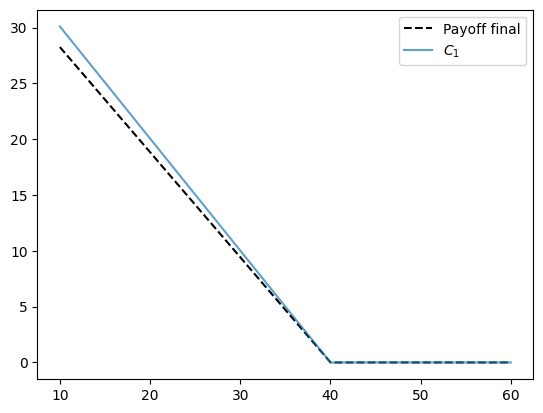

In [22]:
xx = np.linspace(10, 60, 10000).astype(np.float32)


# Plot Continuation Functions (C_n)
plt.plot(xx, payoff_phi(N, xx), label="Payoff final", color='black', linestyle='dashed')
xx_tensor = torch.tensor(xx).reshape(-1, 1).to("cuda" if torch.cuda.is_available() else "cpu")  
Cn =Phi_functions[0](xx_tensor).detach().cpu().numpy().flatten()  
plt.plot(xx, Cn, label=fr"$C_{1}$", alpha=0.7)
plt.legend()

In [30]:
data_train = generate_black_scholes_paths(N-1,2**8).T
data_test = generate_black_scholes_paths(N-1,2**12).T

In [31]:
optimal_price = 5.22  # using longstaf shwartz algorithm

P = [] # list of relative errors :
lambda_ = 50 # paramètre de régularisation

In [ ]:
n_iteration = 1500

Losses = []
for n in range(n_iteration): 

    S_samples = data_train.copy()
    #S_samples = generate_black_scholes_paths(N-1,M).T

    V_values = np.zeros_like(S_samples)
    pi_values = np.ones_like(S_samples)
    V_values[:,-1] = g(S_samples[:,-1])


    print(f'{n+1} Iteration ...')
    

    total_loss = 0
    for l in range(N-2,-1,-1):
        
        # calculating the pi_value at time l :
        X = S_samples[:,l]
        xx = torch.tensor(X, dtype=torch.float32, device=device).reshape(-1, 1)
        with torch.no_grad():
            v_l =Phi_functions[l](xx).cpu().numpy().flatten()


        #pi_values[:,l] = np.exp(-(v_l-g(X))/lambda_) Without clipping
        pi_values[:,l] = np.exp(np.clip(-(v_l-g(X)) / lambda_, -20, 20)) # Clipping for stabilit


        #Calculate the TD-error :
        
        ## construct target vector
        Y = g(S_samples[:,l])*pi_values[:,l]*dt + lambda_*R(pi_values[:,l])*dt+np.exp(-r*dt)*V_values[:,l+1]*(1-pi_values[:,l]*dt)
        yy = torch.tensor(Y, dtype=torch.float32, device=device)

        #print(f"Start training V_{l} ...")
        # entrainement "one step Gadient descent" :
        prediction = Phi_functions[l](xx)
        loss = creterio(prediction, yy.reshape(-1, 1))
        optimizers[l].zero_grad()
        loss.backward()
        optimizers[l].step()
        #print(f"model trained ! ...")
        total_loss+=loss

        # Calculate the new V using the updated parameters 
        with torch.no_grad():
            new_y =Phi_functions[l](xx).cpu().numpy().flatten()
        
        V_values[:,l] = new_y
    


    if n%10 == 0 :
        data_test = generate_black_scholes_paths(N-1,2**12).T
        price = calculate_price(Phi_functions,data_test)
        relative_error = np.abs(optimal_price-price)/price
    
    P.append(relative_error)

    print(f"Epochs {n+1} finished !")
    
    print(f"TOTAL LOSS : {total_loss/N}")
    Losses.append((total_loss/N).detach().cpu().numpy())

1 Iteration ...


NameError: name 'calculate_price' is not defined

In [19]:
plt.plot(P)

NameError: name 'P' is not defined

In [31]:
S_samples = generate_black_scholes_paths(N-1,M).T
calculate_price(Phi_functions,data_test)

3.2759887013695237

-------------

### Change the policy update : 

In [23]:
optimal_price = 5.22  # using longstaf shwartz algorithm

P1 = [] # list of relative errors :

P2 = [] # list of relative errors :

P3 = [] # list of relative errors :

In [47]:
n_iteration = 1200
lambda_ = 0.5 # paramètre de régularisation

Losses = []
pi_values = np.ones_like(data_train)

for n in range(n_iteration): 

    #S_samples = generate_black_scholes_paths(N-1,M).T
    S_samples = data_train.copy()
    V_values = np.zeros_like(S_samples)
    V_values[:,-1] = g(S_samples[:,-1])


    print(f'{n+1} Iteration ...')
    

    total_loss = 0
    for l in range(N-2,-1,-1):
        
      
        #Calculate the TD-error :
        
        ## construct target vector
        X = S_samples[:,l]
        Y = g(S_samples[:,l])*pi_values[:,l]*dt + lambda_*R(pi_values[:,l])*dt+np.exp(-r*dt)*V_values[:,l+1]*(1-pi_values[:,l]*dt)

        xx = torch.tensor(X, dtype=torch.float32, device=device).reshape(-1, 1)
        yy = torch.tensor(Y, dtype=torch.float32, device=device)

        #print(f"Start training V_{l} ...")
        # entrainement "one step Gadient descent" :
        prediction = Phi_functions[l](xx)
        loss = creterio(prediction, yy.reshape(-1, 1))
        optimizers[l].zero_grad()
        loss.backward()
        optimizers[l].step()
        #print(f"model trained ! ...")
        total_loss+=loss

        # Calculate the new V using the updated parameters 
        with torch.no_grad():
            new_y =Phi_functions[l](xx).cpu().numpy().flatten()
        
        V_values[:,l] = new_y
    

    pi_values = np.ones_like(S_samples)
    pi_values[:,:-1] = np.exp(np.clip(-(V_values[:,:-1]-g(S_samples[:,:-1])) / lambda_, -10, 10))
    
    if n%5 == 0 :
        price = calculate_price(Phi_functions,data_test)
        relative_error = np.abs(optimal_price-price)/price

    
    P3.append(relative_error)
    print(f"Epochs {n+1} finished !")
    print(f"TOTAL LOSS : {total_loss/N}")
    Losses.append((total_loss/N).detach().cpu().numpy())


1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 6.126134395599365
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 6.388211727142334
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 6.387638092041016
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 6.387120723724365
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 6.386616230010986
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 6.386209964752197
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 6.385829925537109
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 6.385434150695801
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 6.3850483894348145
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 6.3846755027771
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 6.3844099044799805
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 6.384335994720459
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 6.384524822235107
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 6.384728908538818
15 Iteration ...
Epochs 15 finished !
TOTAL LOSS : 6

In [53]:
def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)


def calculate_price(Phi_functions,data_train):

    
    payoffs = np.empty_like(data_train)
    for n in range(0, N):
        payoffs[:,n] = payoff_phi(n, data_train[:,n])
    
    payoff_opt = payoffs[:,-1].copy() # Payoffs optimaux à l'instant t = N

    for n in range(N-1,0,-1):

        xx = torch.tensor(data_train[:, n], dtype=torch.float32, device=device).reshape(-1, 1)
        with torch.no_grad():
                continuation_function = Phi_functions[n-1](xx).cpu().numpy().flatten()

        stop_at_n = payoffs[:,n] >= continuation_function
        payoff_opt[stop_at_n] = payoffs[stop_at_n,n].copy() # Payoffs optimaux à l'instant t = n


    payoff_opt.mean()
    

    return payoff_opt.mean()

In [54]:
calculate_price(Phi_functions,data_test)

5.200518849412028

In [36]:
def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)



def calculate_price(Phi_functions):

    S_samples = generate_black_scholes_paths(N-1,M).T
    payoffs  = np.maximum(K-S_samples,0)
    payoff_opt = payoffs[:,-1]
    
    for n in range(N-2, -1, -1):
        print(f"Training for time step {n}")

        xx = torch.tensor(S_samples[:, n], dtype=torch.float32, device=device).reshape(-1, 1)

        with torch.no_grad():
            continuation_function = Phi_functions[n](xx).cpu().numpy().flatten()

        # Update payoff values based on stopping condition
        stop_at_n = payoffs[:, n] >= continuation_function
        payoff_opt[stop_at_n] = payoffs[stop_at_n, n]
    

    return payoff_opt.mean()